In [1]:
!pip install pytorch-nlp
import torch
from torch.autograd import Variable
import numpy
import sys
from torchnlp.datasets import penn_treebank_dataset
from torch import nn
import matplotlib.pyplot as plt
from google.colab import drive

     |████████████████████████████████| 92kB 5.8MB/s 


In [2]:
drive.mount('/content/drive')
data_dir = "/content/drive/Shared drives/Deep Learning Course/ex2_204094213_301861902/data"
train_set, val_set, test_set = penn_treebank_dataset(data_dir, train=True, dev=True, test=True)

class WordDict:
  def __init__(self):
    self.word2idx = {}
    self.idx2word = []
  
  def add_word(self, word):
    if word not in self.word2idx:
      self.idx2word.append(word)
      self.word2idx[word] = len(self.idx2word) - 1
    return self.word2idx[word]
  
  def __len__(self):
    return len(self.idx2word)
  
class Corpus:
  def __init__(self, train_set, val_set, test_set):
    self.word_dict = WordDict()
    self.train = self.tokenize(train_set)
    self.val = self.tokenize(val_set)
    self.test = self.tokenize(test_set)

  def tokenize(self, data_set):
    tokens = len(data_set)
    for word in data_set:
      self.word_dict.add_word(word)
    
    ids = torch.LongTensor(tokens)
    for token, word in enumerate(data_set):
      ids[token] = self.word_dict.word2idx[word]
    
    return ids

def batchify(data, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    if torch.cuda.is_available():
        data = data.cuda()
    return data

def get_batch(source, i):
  seq_len = min(sequnce_length, len(source) - 1 - i)
  data = Variable(source[i:i+seq_len])
  target = Variable(source[i+1:i+1+seq_len].view(-1))
  return data, target

corpus = Corpus(train_set, val_set, test_set)

batch_size = 32
sequnce_length = 35
train_data = batchify(corpus.train, batch_size)
val_data = batchify(corpus.val, batch_size)
test_data = batchify(corpus.test, batch_size)

Mounted at /content/drive


In [3]:
class RnnModel(nn.Module):
  def __init__(self, rnn_type, num_tokens, num_input=200, num_hidden=200, num_layers=2, dropout_p=0.5):
    super(RnnModel, self).__init__()
    assert rnn_type in ['LSTM', 'GRU'], "rnn_type must be one of ['LSTM', GRU'], got %s" % rnn_type
    self.dropout_p = dropout_p
    self.rnn_type = rnn_type
    self.num_layers = num_layers
    self.num_hidden = num_hidden
    
    self.embedding = nn.Embedding(num_tokens, num_input)
    self.rnn = getattr(nn, rnn_type)(num_input, num_hidden, num_layers, dropout=dropout_p)
    self.dropout = nn.Dropout(dropout_p)
    # maybe tie weight of emmbedding and hidden2token?
    self.hidden2token = nn.Linear(num_hidden, num_tokens)
    assert num_input == num_hidden, "For weight tieing embedding size must be same as hidden size"
    self.hidden2token.weight = self.embedding.weight
    
    self.init_weights()

  def init_weights(self):
    init_range = 0.1
    self.embedding.weight.data.uniform_(-init_range, init_range)
    self.hidden2token.bias.data.fill_(0.)
    self.hidden2token.weight.data.uniform_(-init_range, init_range)
  
  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    if self.rnn_type == 'LSTM':
        return (Variable(weight.new(self.num_layers, batch_size, self.num_hidden).zero_()).to(weight.device),
                Variable(weight.new(self.num_layers, batch_size, self.num_hidden).zero_()).to(weight.device))
    else:
        return Variable(weight.new(self.num_layers, batch_size, self.num_hidden).zero_())

  def forward(self, input, hidden):
    embedding = self.dropout(self.embedding(input))
    out, hidden = self.rnn(embedding, hidden)
    out = self.dropout(out)
    tokens = self.hidden2token(out.view(out.shape[0] * out.shape[1], out.shape[2]))
    return tokens.view(out.shape[0], out.shape[1], tokens.shape[1]), hidden 
    
def repackage_hidden(h):
  """Wraps hidden states in new Variables, to detach them from their history."""
  if type(h) == tuple:
      return tuple(Variable(v) for v in h)
  else:
      return Variable(h.data)

In [4]:
def train_epoch(rnn_model, train_data, loss_fn, optimizer):
  rnn_model.train()
  total_loss = 0
  num_tokens = len(corpus.word_dict)
  hidden = rnn_model.init_hidden(batch_size)
  for i in range(0, train_data.shape[0] - 1, sequnce_length):
    optimizer.zero_grad()
    data, targets = get_batch(train_data, i)
    hidden = repackage_hidden(hidden)
    output, hidden = rnn_model(data, hidden)
    loss = loss_fn(output.view(-1, num_tokens), targets)
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(rnn_model.parameters(), 1.)
    optimizer.step()

    total_loss += len(data) * loss.item()
  return rnn_model, total_loss / len(train_data)


def evaluate(rnn_model, eval_data, loss_fn):
  rnn_model.eval()
  with torch.no_grad():
    total_loss = 0
    num_tokens = len(corpus.word_dict)
    hidden = rnn_model.init_hidden(batch_size)
    for i in range(0, eval_data.shape[0] - 1, sequnce_length):
      data, targets = get_batch(eval_data, i)
      output, hidden = rnn_model(data, hidden)
      output_flat = output.view(-1, num_tokens)
      total_loss += len(data) * loss_fn(output_flat, targets).item()
      hidden = repackage_hidden(hidden)
  return total_loss / len(eval_data)

def save_model(path, model):
  pass

def train(rnn_model, train_data, val_data, loss_fn, optimizer, num_epochs, lr_scheduler=None):
  train_losses = []
  val_losses = []
  best_val_loss = sys.float_info.max
  best_model = None

  for epoch in range(num_epochs):
    rnn_model, train_loss = train_epoch(rnn_model, train_data, loss_fn, optimizer)
    train_losses.append(train_loss)
    val_loss = evaluate(rnn_model, val_data, loss_fn)
    val_losses.append(val_loss)
    if lr_scheduler is not None:
      lr_scheduler.step()
    print("Epoch %d:\n\t train loss %f, train preplexity %f\n\t validation loss %f, validation preplexity %f" % (epoch, train_loss, numpy.exp(train_loss), val_loss, numpy.exp(val_loss)))

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_model = rnn_model
  
  return best_model, train_losses, val_losses


In [5]:
num_tokens = len(corpus.word_dict)

########## USER CONTROL ##########
dropout = 0.5 # change to 0 for no dropout
type_name = 'LSTM' # valid options are 'LSTM' / 'GRU'
########## USER CONTROL ##########

rnn_model = RnnModel(type_name, num_tokens, dropout_p=dropout)
if torch.cuda.is_available():
  rnn_model.cuda()

loss_fn = nn.CrossEntropyLoss()
# lr = 5.0
# optimizer = torch.optim.SGD(rnn_model.parameters(), lr=lr)
lr = 1e-3
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr)
lr_scheduler = None # torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
num_epochs = 35
best_model, train_losses, val_losses = train(rnn_model, train_data, val_data, loss_fn, optimizer, num_epochs, lr_scheduler)
train_preplexity = [numpy.exp(x) for x in train_losses]
val_preplexity = [numpy.exp(x) for x in val_losses]

Epoch 0:
	 train loss 6.449212, train preplexity 632.204069
	 validation loss 5.965126, validation preplexity 389.602273
Epoch 1:
	 train loss 5.879431, train preplexity 357.605866
	 validation loss 5.572773, validation preplexity 263.162959
Epoch 2:
	 train loss 5.609473, train preplexity 273.000366
	 validation loss 5.377536, validation preplexity 216.488209
Epoch 3:
	 train loss 5.448410, train preplexity 232.388376
	 validation loss 5.252516, validation preplexity 191.046278
Epoch 4:
	 train loss 5.338758, train preplexity 208.253882
	 validation loss 5.164085, validation preplexity 174.877426
Epoch 5:
	 train loss 5.256136, train preplexity 191.739124
	 validation loss 5.094414, validation preplexity 163.108291
Epoch 6:
	 train loss 5.190699, train preplexity 179.594025
	 validation loss 5.041650, validation preplexity 154.725029
Epoch 7:
	 train loss 5.136463, train preplexity 170.113073
	 validation loss 4.997204, validation preplexity 147.998768
Epoch 8:
	 train loss 5.093190, 

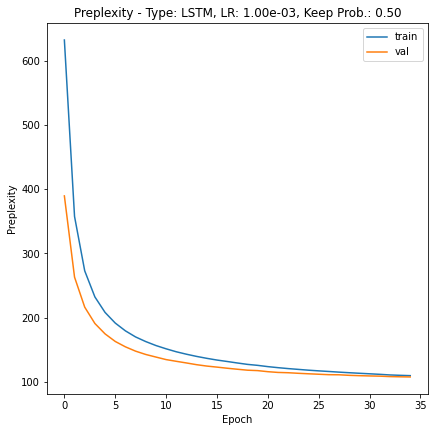

In [6]:
def plot_graphs(train_preplexity, val_preplexity, lr, keep_prob, type_name):
  plt.figure(figsize=(15, 15))
  plt.subplot(2, 2, 1)
  plt.plot(train_preplexity)
  plt.plot(val_preplexity)
  plt.legend(['train', 'val'])
  plt.xlabel("Epoch")
  plt.ylabel("Preplexity")
  plt.title("Preplexity - Type: %s, LR: %.2e, Keep Prob.: %.2f" % (type_name, lr, keep_prob))

plot_graphs(train_preplexity, val_preplexity, lr=lr, keep_prob=1. - dropout, type_name=type_name)